In [33]:
import os
import sys
sys.path.append('./')
sys.path.append('../')

import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import SklearnClassifier
from sklearn.datasets import load_wine

from Core.dataset import CDataset
from Core.tSNE import tSNEPlots

# Step 1: Load dataset

## Wine Dataset

In [12]:
data = load_wine()
X, y = data.data, data.target

# Standardize features for stability
scaler = StandardScaler()
X = scaler.fit_transform(X)

print(np.unique(y, return_counts=True))


(array([0, 1, 2]), array([59, 71, 48], dtype=int64))


## Kyoto

In [13]:
cDATA = 'Kyoto'

objDS = CDataset()

strFileName =  r'../../DATA/Kyoto2015DS.csv'
#strPath = os.path.join(strRoot, strFileName)
X, y = objDS.GetKyotoDataset(strFileName)
print('Kyoto:', X.shape, y.shape)

fTestSize = 0.9

CDataset Object Created
label
0    30000
1    30000
dtype: int64
Kyoto: (60000, 13) (60000, 1)


## Spilt Data

In [14]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=fTestSize, 
                                                    random_state=42)

In [15]:
print('Training Data:', X_train.shape, y_train.shape)
print('Testing Data:', X_test.shape, y_test.shape)

print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

Training Data: (6000, 13) (6000, 1)
Testing Data: (54000, 13) (54000, 1)
(array([0, 1], dtype=int64), array([3082, 2918], dtype=int64))
(array([0, 1], dtype=int64), array([26918, 27082], dtype=int64))


## One Hot encoding

In [16]:
enc = OneHotEncoder()
# Training
enc.fit(y_train)  
y_train_cat = enc.transform(y_train).toarray()

# Training
enc.fit(y_test)  
y_test_cat = enc.transform(y_test).toarray()

#print(y_train[0:5])
#print(y_test_cat[0:5])

# Step 2: Train a simple classifier

In [17]:
# model = RandomForestClassifier() not working
#model = SVC(C=1.0, kernel="rbf")
model = SVC(C=1.0, kernel="rbf")
model.fit(X_train, y_train)

# Evaluate on clean test set
acc_clean = model.score(X_test, y_test)
print(f"Accuracy on clean test set: {acc_clean:.4f}")

c:\Users\3058388\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy on clean test set: 0.6480


# Step 3: Wrap model for ART

In [18]:
classifier = SklearnClassifier(model=model)

classifier.fit(X_train, y_train_cat)

predictions = classifier.predict(X_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test_cat, axis=1)) / len(y_test_cat)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 64.79814814814814%


# Step 4: Create adversarial attack (FGSM)

In [19]:
attack = FastGradientMethod(estimator=classifier, eps=0.1)

# Step 5: Generate adversarial examples

In [22]:
print(type(X_test), X_test.shape)

print(X_test[0:1000,].shape)

<class 'numpy.ndarray'> (54000, 13)
(1000, 13)


In [27]:
nSamples = 1000
X_test_adv = attack.generate(x=X_test[0:nSamples,])
print(X_test_adv.shape)

(1000, 13)


# Step 6: Evaluate on adversarial set

In [28]:
norm_adv = model.score(X_test[0:nSamples,], y_test[0:nSamples,])
print(f"Accuracy on normal test set: {norm_adv:.4f}")

acc_adv = model.score(X_test_adv, y_test[0:nSamples,])
print(f"Accuracy on adversarial test set: {acc_adv:.4f}")

Accuracy on normal test set: 0.6310
Accuracy on adversarial test set: 0.6310


In [26]:
# Optional: Compare a few original vs adversarial samples
print("\nOriginal sample (first row):", X_test[0])
print("Adversarial sample (first row):", X_test_adv[0])


Original sample (first row): [4.6700e-04 4.3000e+01 5.4351e+04 2.1000e+01 0.0000e+00 0.0000e+00
 0.0000e+00 2.0000e+01 9.2000e+01 0.0000e+00 0.0000e+00 1.0000e+02
 5.3000e+01]
Adversarial sample (first row): [-9.95330e-02  4.29000e+01  5.43511e+04  2.09000e+01  1.00000e-01
  1.00000e-01  1.00000e-01  1.99000e+01  9.19000e+01  1.00000e-01
  1.00000e-01  9.99000e+01  5.31000e+01]


In [35]:
arr_zeros = np.zeros(nSamples).reshape(-1,1)
listOrig = np.hstack((X_test[0:nSamples,], arr_zeros))
print(listOrig.shape)

arr_ones = np.ones(nSamples).reshape(-1,1)
listAdv = np.hstack((X_test_adv, arr_ones))
print(listAdv.shape)

listData = np.vstack((listOrig, listAdv))
dfCols = ['Bin_'+str(i) for i in range(X_test.shape[1])]
dfCols.append('Labels')
#print(dfCols)
df = pd.DataFrame(listData, columns=dfCols)

(1000, 14)
(1000, 14)


Data for tSNE (2000, 15)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.004s...
[t-SNE] Computed neighbors for 2000 samples in 0.039s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 15.216140
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.209717
[t-SNE] KL divergence after 300 iterations: 0.822808


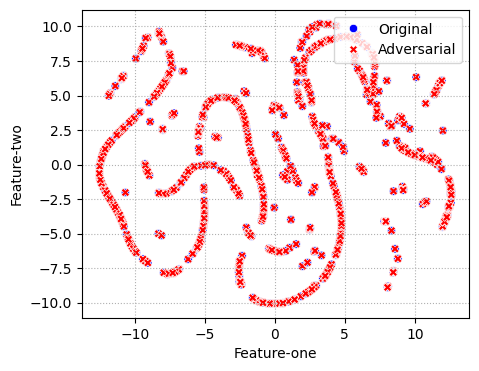

In [37]:
strOutputFile = '../local-data/tsneKyoto_AT.pdf'

tSNEPlots(df, listLabels=['Original', 'Adversarial'], 
              strOutputFile=strOutputFile)